In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook

In [2]:
## Read the Excel sheet names
pathToFile = r"./data/DataAll.xlsx"
keysToSearch = load_workbook(pathToFile,read_only=True).sheetnames

In [3]:
## Import and save as a dict(pd.DataFrame)
usecols = ["Sample Name",
           "Sample ID",
           "Analyte Peak Area (counts)",
           "Analyte Peak Height (cps)",
           "Calculated Concentration (ng/mL)"]

allData = {k:None for k in keysToSearch}
for key in keysToSearch:
    allData[key] = pd.read_excel(pathToFile,sheet_name=key,usecols=usecols,na_values=['< 0', 'No Intercept'])

## Read the time metadata for each sample
pathToFile = r"./data/Time.xlsx"
time = pd.read_excel(pathToFile,sheet_name="Time",index_col="Sample ID")

In [4]:
#Filter data not corresponding to effluent
allEffluent = {k:None for k in keysToSearch}
for key,data in allData.items():
    allEffluent[key] = data
    allEffluent[key] = allEffluent[key][allEffluent[key]["Sample Name"].str.contains("standard") == False]
    allEffluent[key] = allEffluent[key][allEffluent[key]["Sample Name"].str.contains("Influent") == False]

In [5]:
#Extract only concentrations and group samples
strConc = 'Calculated Concentration (ng/mL)'
strID = 'Sample Name'
allGroupedSamples = {k:None for k in keysToSearch}
for key,data in allEffluent.items():
    allGroupedSamples[key] = data[[strID,strConc]].groupby(by=[strID],as_index=True,sort=False)

In [6]:
## Calculate mean and stdev of each group of three samples
allStatistics = {k:None for k in keysToSearch}
for key,data in allGroupedSamples.items():
    allStatistics[key] = pd.concat([time[["Cumulative Time (min)"]],
                                    data.mean().rename(columns={strConc:"mean"}),
                                    data.std().rename(columns={strConc:"std"}),
                                    data.count().rename(columns={strConc:"nSamples"})], axis = 1)

In [7]:
##### Influent

#Filter data not corresponding to influent
allInfluent = {k:None for k in keysToSearch}
for key,data in allData.items():
    allInfluent[key] = data[data["Sample Name"].str.contains("Influent") == True]

#Extract only concentrations and group samples
allGroupedInfluent = {k:None for k in keysToSearch}
for key,data in allInfluent.items():
    allGroupedInfluent[key] = data[[strID,strConc]].groupby(by=[strID],as_index=True,sort=False)

## Calculate mean and stdev of each group of three samples
allStatsInfluent = {k:None for k in keysToSearch}
for key,data in allGroupedInfluent.items():
    allStatsInfluent[key] = pd.concat([data.mean().rename(columns={strConc:"mean"}),
                                       data.std().rename(columns={strConc:"std"}),
                                       data.count().rename(columns={strConc:"nSamples"})], axis = 1)

/home/edsaa/venv/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/edsaa/venv/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


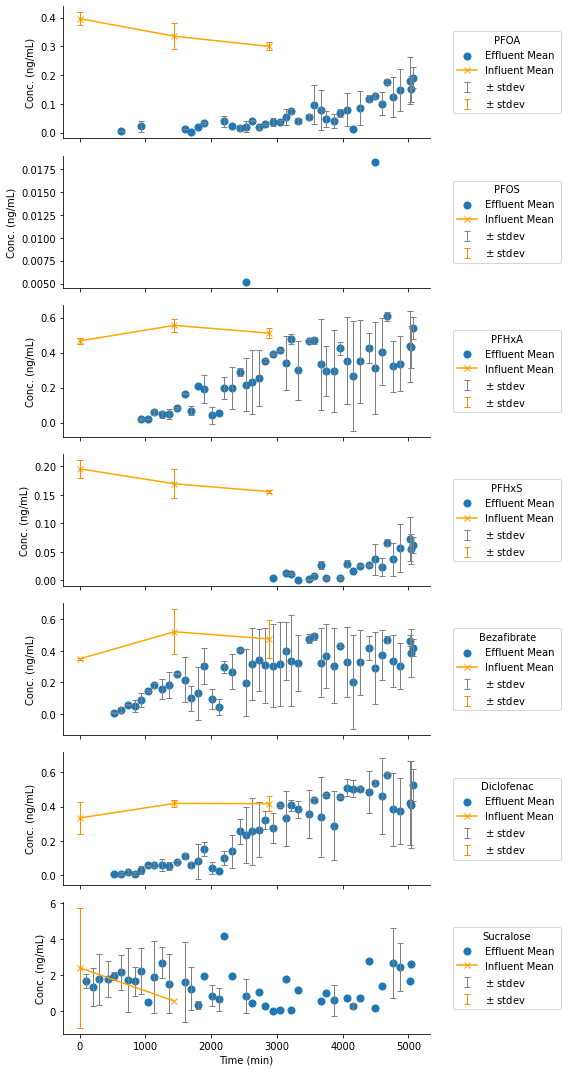

In [8]:
fig,axs = plt.subplots(len(allStatistics),1,sharex=True,tight_layout=True,figsize=(8,15))
for ax,(key,statistics) in zip(axs,allStatistics.items()):
    ax.scatter(statistics["Cumulative Time (min)"],statistics["mean"],
               s=50,label="Effluent Mean ")
    ax.errorbar(statistics["Cumulative Time (min)"],statistics["mean"],statistics["std"],
                lw=0,c='k',marker=None,ecolor='gray',elinewidth=1,capsize=3,label=r'$\pm$ stdev')
    ax.set_ylabel("Conc. (ng/mL)")
    #ax.set_xlim(0,statistics["Cumulative Time (min)"].max())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_position(('data', 0))
ax.set_xlabel("Time (min)")

TEMPTIMES = [0,24*60,48*60]

for ax,(key,statistics) in zip(axs,allStatsInfluent.items()):
    ax.plot(TEMPTIMES,statistics['mean'],marker='x',label="Influent Mean",c="orange")
    ax.errorbar(TEMPTIMES,statistics['mean'],statistics['std'],
            lw=0,c='k',marker=None,ecolor='darkorange',elinewidth=1,capsize=3,label=r'$\pm$ stdev')
    ax.legend(title=key,loc="center left",bbox_to_anchor=(1.05,0.5))
fig.savefig("Plots.png",transparent=False)
plt.show()

In [9]:
allStatsInfluent['PFOA']

,mean,std,nSamples
Sample Name,,,
Influent -1,0.396000,0.021703,3
Influent -2,0.335000,0.045044,3
Influent -3,0.299667,0.013796,3
